# 구글 플레이스토어 명상앱 데이터분석 프로젝트

In [82]:
# 모듈 불러오기
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pymysql
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib.request

In [3]:
# 데이터베이스에서 크롤링한 목록 가져오기
connection = pymysql.connect(
    host='localhost',
    database='playstore',
    user='root',
    charset='utf8mb4'
)

cursor = connection.cursor()
cursor.execute('SELECT * FROM apps')
results = cursor.fetchall()
cursor.close()

for v in results:
    print(v)


(1, 100, 'com.discord', 'Discord - 친구와 대화, 영상 채팅, 모임 madeBy Discord Inc.', datetime.datetime(2023, 4, 19, 15, 15, 56))
(2, 200, 'com.instagram.android', 'Instagram madeBy Instagram', datetime.datetime(2023, 4, 19, 17, 7, 1))
(3, 200, 'com.instagram.android', 'Instagram madeBy Instagram', datetime.datetime(2023, 4, 19, 17, 46, 25))
(4, 10000, 'com.kakao.talk', '카카오톡 KakaoTalk madeBy Kakao Corp.', datetime.datetime(2023, 4, 20, 10, 38, 8))
(5, 1590, 'com.mabopractice.app', '마보 - 명상, 수면, 명상음악, 마음챙김 madeBy 마보', datetime.datetime(2023, 4, 20, 11, 40, 22))
(6, 1590, 'com.mabopractice.app', '마보 - 명상, 수면, 명상음악, 마음챙김 madeBy 마보', datetime.datetime(2023, 4, 20, 11, 41, 21))
(7, 900, 'com.mabopractice.app', '마보 - 명상, 수면, 명상음악, 마음챙김 madeBy 마보', datetime.datetime(2023, 4, 24, 11, 0, 57))
(8, 900, 'com.mindclass.android', '코끼리 – 수면, 명상 madeBy 코끼리 명상', datetime.datetime(2023, 4, 24, 11, 5, 6))
(9, 900, 'com.calm.android', 'Calm - 명상, 수면, 휴식 madeBy Calm.com, Inc.', datetime.datetime(2023, 4, 24, 11, 9,

In [4]:
# init 
init = {'mabo':None, 'kokkiri':None, 'calm':None}

# 데이터베이스에서 수집한 리뷰 가져오기
ids = {'mabo':7, 'kokkiri':8, 'calm':9}
reviews = init

cursor = connection.cursor()
for key, value in ids.items():
    cursor.execute('SELECT * FROM reviews WHERE app_id = %s', value)
    result = cursor.fetchall()
    reviews[key] = pd.DataFrame(result)
cursor.close()



In [5]:
# 대략적인 정보 확인
reviews['calm'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       900 non-null    int64         
 1   1       900 non-null    int64         
 2   2       900 non-null    object        
 3   3       900 non-null    float64       
 4   4       900 non-null    object        
 5   5       900 non-null    object        
 6   6       900 non-null    int64         
 7   7       900 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.4+ KB


In [6]:
# column 이름 바꿔주기
for key,value in reviews.items():
    reviews[key].columns = ['id', 'app_id', 'user_name', 'rating', 'reviewed_at', 'content', 'useful_count', 'created_at']
    
reviews['mabo'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            900 non-null    int64         
 1   app_id        900 non-null    int64         
 2   user_name     900 non-null    object        
 3   rating        900 non-null    float64       
 4   reviewed_at   900 non-null    object        
 5   content       900 non-null    object        
 6   useful_count  900 non-null    int64         
 7   created_at    900 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.4+ KB


In [7]:
# reviewed_at date로 변경해주기
for key, value in reviews.items():
    reviews[key]['reviewed_at'] = pd.to_datetime(reviews[key]['reviewed_at'])

reviews['calm']['reviewed_at'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 900 entries, 0 to 899
Series name: reviewed_at
Non-Null Count  Dtype         
--------------  -----         
900 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.2 KB


In [8]:
# 년, 월별로 리뷰 개수 확인
df = pd.DataFrame()
for key, value in init.items():
    df[key] = reviews[key].groupby(reviews[key]['reviewed_at'].dt.strftime("%Y-%m"))['id'].count()

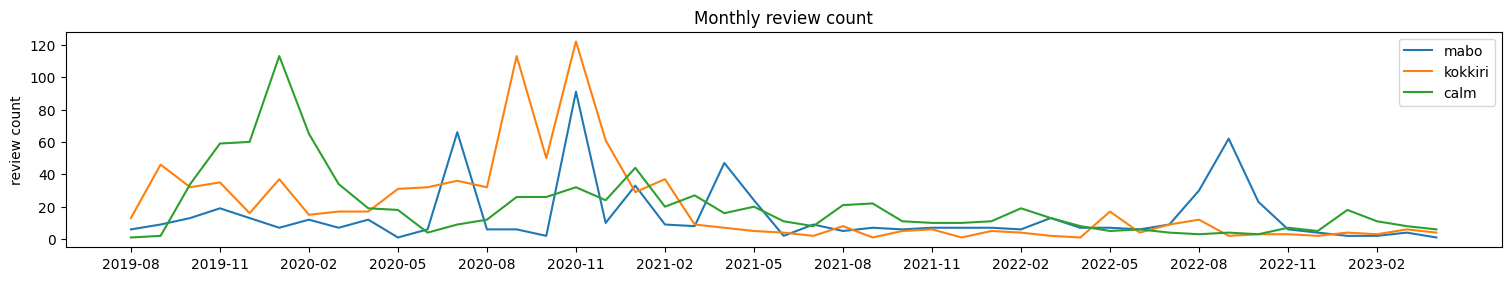

In [9]:
# 열 <-> 행
df.transpose()

# 정렬
df.sort_index(ascending=True,inplace=True)

# na 드랍.
droped = df.dropna()


# 그래프

plt.figure(figsize=(15, 2.7),layout='constrained')

for key, value in init.items():
    plt.plot(droped[key], label=key)

# 표 꾸미기
plt.xticks(droped['calm'].index[::3]) 
plt.legend()
plt.title("Monthly review count")
plt.ylabel("review count")
plt.show()


In [107]:
# useful count가 높은 데이터는 rating 이 어떻게 되어 있을까?

for key,value in init.items():
    b = reviews[key].sort_values(by='useful_count', ascending=False).head(50)
    data = b.groupby('rating')['rating'].count()
    print(key)
    print(data)



mabo
rating
1.0     2
2.0     2
3.0     5
4.0     9
5.0    32
Name: rating, dtype: int64
kokkiri
rating
1.0    11
2.0     1
3.0     6
4.0    11
5.0    21
Name: rating, dtype: int64
calm
rating
1.0    35
2.0     1
4.0     1
5.0    13
Name: rating, dtype: int64


# 데이터 모델링

In [11]:

tokenizer = Tokenizer()

# 데이터 로드
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",
    filename="ratings_total.txt",
)

total_data = pd.read_table("ratings_total.txt", names=["ratings", "reviews"])
total_data["label"] = np.select([total_data.ratings > 3], [1], default=0)

In [12]:
kiwi = Kiwi()
stopwords = [
    "도",
    "는",
    "다",
    "의",
    "가",
    "이",
    "은",
    "한",
    "에",
    "하",
    "고",
    "을",
    "를",
    "인",
    "듯",
    "과",
    "와",
    "네",
    "들",
    "듯",
    "지",
    "임",
    "게",
]

In [78]:
# 중복제거
total_data.drop_duplicates(subset=["reviews"], inplace=True)

# 데이터 정제
total_data["reviews"] = total_data["reviews"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
total_data["reviews"].replace("", np.nan, inplace=True)

# 토큰화
total_data["tokenized"] = total_data["reviews"].apply(lambda x : [token[0] for token in kiwi.tokenize(x) if token[0] not in stopwords])

In [39]:
# 긍정 부정 체크
negative_words = np.hstack(total_data[total_data.label == 0]["tokenized"].values)
positive_words = np.hstack(total_data[total_data.label == 1]["tokenized"].values)


negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('었', 64699), ('어요', 54541), ('어', 46565), ('ᆫ', 46402), ('.', 44727), ('네요', 41752), ('어서', 41406), ('는데', 28224), ('안', 26501), ('거', 21797), ('..', 20229), ('ᆸ니다', 19272), ('너무', 18098), ('ᆯ', 18064), ('되', 17787), ('있', 17508), ('쓰', 15797), ('나', 14793), ('것', 13810), ('...', 13048)]
[('어요', 75658), ('좋', 50084), ('었', 47083), ('.', 35859), ('어', 34835), ('어서', 29326), ('ᆫ', 27383), ('네요', 26464), ('ᆸ니다', 24848), ('잘', 24650), ('구매', 21365), ('습니다', 18537), ('있', 16549), ('배송', 16233), ('는데', 16135), ('~', 15781), ('쓰', 14910), ('ᆯ', 13484), ('먹', 12828), ('빠르', 12576)]


In [40]:
# 리뷰의 평균 길이 체크
text_len = total_data[total_data['label']==1]['tokenized'].map(lambda x: len(x))
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = total_data[total_data['label']==0]['tokenized'].map(lambda x: len(x))
print('부정 리뷰의 평균 길이 :', np.mean(text_len))


긍정 리뷰의 평균 길이 : 15.616339679649435
부정 리뷰의 평균 길이 : 20.215847131209046


In [41]:
# 모델에 넣을 (X,Y)값 세팅
X_train = total_data['tokenized'].values
y_train = total_data['label'].values

# X값 입력
tokenizer.fit_on_texts(X_train)

In [43]:
# 희귀 단어 체크

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 47864
등장 빈도가 1번 이하인 희귀 단어의 수: 27493
단어 집합에서 희귀 단어의 비율: 57.439829516964735
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7676231825384083


In [44]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 20373


In [46]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 17.916116413550235


In [47]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


max_len = 80
below_threshold_len(max_len, X_train)
X_train = tokenizer.texts_to_sequences(X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99849930968246


In [50]:
X_train = pad_sequences(X_train, maxlen=max_len)

In [ ]:
# 모델 컴파일

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

mc = ModelCheckpoint('model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[mc], batch_size=64, validation_split=0.2)

In [93]:
loaded_model = load_model('new_model.h5')

In [94]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    return True
  else:
    return False

# 리뷰와 별점 분석

## 긍정과 부정리뷰 분석

In [95]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

2023-04-26 20:43:16.816695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-26 20:43:16.903469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 489ms/step


False

In [96]:
for key, value in reviews.items():
    for index, row in value.iterrows():
        positive = sentiment_predict(row['content'])
        if positive:
            reviews[key].at[index, 'isPositive'] = 1
        else:
            reviews[key].at[index, 'isPositive'] = 0
    


1/1 [==============================] - 0s 27ms/step


In [57]:
print(reviews['mabo'].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            900 non-null    int64         
 1   app_id        900 non-null    int64         
 2   user_name     900 non-null    object        
 3   rating        900 non-null    float64       
 4   reviewed_at   900 non-null    datetime64[ns]
 5   content       900 non-null    object        
 6   useful_count  900 non-null    int64         
 7   created_at    900 non-null    datetime64[ns]
 8   isPositive    900 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 63.4+ KB
None


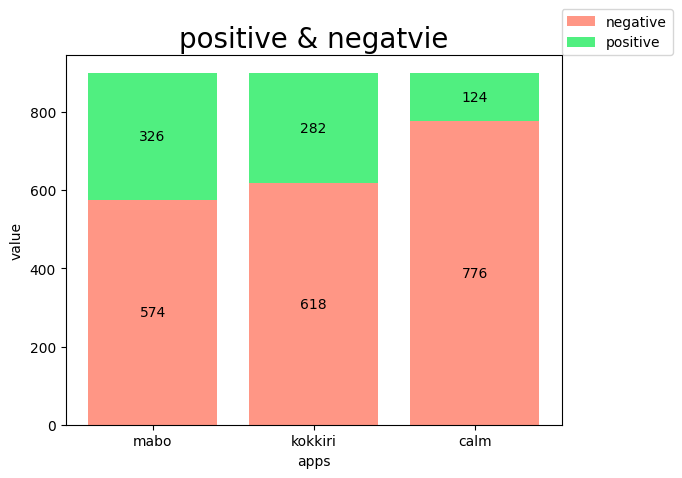

In [110]:
# 긍정리뷰 부정리뷰 비율 시각화
fig, ax = plt.subplots()

labels = []
positive_list = []
negative_list = []
count = {'mabo':None, 'kokkiri':None, 'calm':None}

for key, value in reviews.items():
    total = reviews[key]['isPositive'].count()
    positive = reviews[key]['isPositive'].sum()
    negative = total - positive
    labels.append(key)
    positive_list.append(positive)
    negative_list.append(negative)

# 긍정값과 부정값 퍼센트 비율 바 그리기
p = ax.bar(labels, negative_list, label='negative', color='#FF9685')
b = ax.bar(labels, positive_list, bottom=negative_list, label='positive', color='#50EF80')
ax.bar_label(p, label_type='center')
ax.bar_label(b, label_type='center')

# 축과 제목 설정
ax.set_xlabel('apps')
ax.set_ylabel('value')
ax.set_title('positive & negatvie', fontsize=20)
# 범례 표시
ax.legend(loc=(1,1))

# 그래프 출력
plt.show()


In [ ]:

fig, ax = plt.subplots(3,5, figsize=(15,8))
labels = ['positive', 'negatvie']
apps = ['calm', 'kokkiri', 'mabo']

for key, value in enumerate(apps):
    grouped = reviews[value].groupby('rating')

    for i in range(1,6):
        col = grouped.get_group(i)
        totalCnt = col['isPositive'].count()
        positiveCnt = col['isPositive'].sum()
        negativeCnt = totalCnt - positiveCnt
        ax[key,i-1].pie([positiveCnt, negativeCnt], labels=labels, autopct='%1.1f', colors=['#50EF80', '#FF9685'])
        ax[key,i-1].set_title("{} rating {}.0".format(value, i))

fig.suptitle("Rating", fontsize=20)


# 번외

(-0.5, 899.5, 899.5, -0.5)

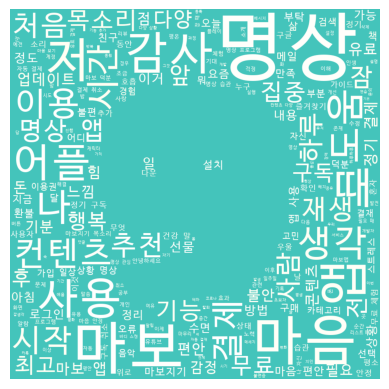

In [68]:
# from matplotlib.font_manager import FontManager


font_location = "/Users/sehun/Library/Fonts/D2Coding-Ver1.3.2-20180524-all.ttc"

# fm = FontManager()
# fm.addfont(font_location)
plt.rcParams["font.family"] = "AppleGothic"
plt.rc("axes",unicode_minus=False)
calmNouns = []
for v in reviews['mabo']['content']:
    tokenized = kiwi.tokenize(v)
    for word in tokenized:
        if word[1] == "NNP" or word[1] == "NNG" or word[1] == "NP":
            calmNouns.append(word[0])
    

text = " ".join(calmNouns)
fig = plt.figure()
mask = np.array(Image.open('mabo.jpeg'))
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ffffff', '#fffff1'])
wordcloud = WordCloud(background_color = '#44C4BB', max_words=250, mask=mask, colormap=cmap, font_path=font_location).generate(text)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

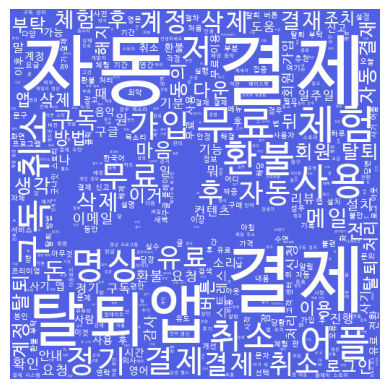

In [77]:
# from matplotlib.font_manager import FontManager


font_location = "/Users/sehun/Library/Fonts/D2Coding-Ver1.3.2-20180524-all.ttc"

# fm = FontManager()
# fm.addfont(font_location)
plt.rcParams["font.family"] = "AppleGothic"
plt.rc("axes",unicode_minus=False)
calmNouns = []
for v in reviews['calm']['content']:
    tokenized = kiwi.tokenize(v)
    for word in tokenized:
        if word[1] == "NNP" or word[1] == "NNG" or word[1] == "NP":
            calmNouns.append(word[0])
    

text = " ".join(calmNouns)
fig = plt.figure()
mask = np.array(Image.open('calm.png'))
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ffffff', '#fffff1'])
wordcloud = WordCloud(background_color = '#515FE3', max_words=4000, mask=mask, colormap=cmap, font_path=font_location).generate(text)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

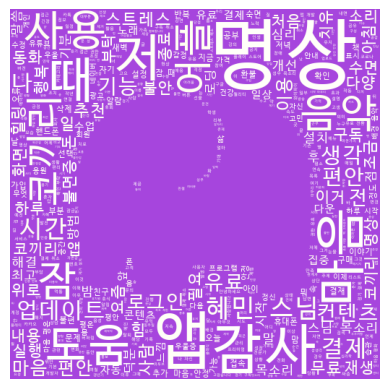

In [76]:
# from matplotlib.font_manager import FontManager


font_location = "/Users/sehun/Library/Fonts/D2Coding-Ver1.3.2-20180524-all.ttc"

# fm = FontManager()
# fm.addfont(font_location)
plt.rcParams["font.family"] = "AppleGothic"
plt.rc("axes",unicode_minus=False)
calmNouns = []
for v in reviews['kokkiri']['content']:
    tokenized = kiwi.tokenize(v)
    for word in tokenized:
        if word[1] == "NNP" or word[1] == "NNG" or word[1] == "NP":
            calmNouns.append(word[0])
    

text = " ".join(calmNouns)
fig = plt.figure()
mask = np.array(Image.open('kokkiri.png'))
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ffffff', '#fffff1'])
wordcloud = WordCloud(background_color = '#A645DD', max_words=4000, mask=mask, colormap=cmap, font_path=font_location).generate(text)
plt.imshow(wordcloud)
plt.axis('off')